In [180]:
# Here we import all libraries
import numpy as np
import gym
import matplotlib.pyplot as plt
import os
import torch
import random
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from collections import deque 
import sys
env = gym.make("CartPole-v0")

In [181]:
#Hyperparameters
episodes = 5000
eps = 1.0
learning_rate = 0.1
discount_factor = 0.99
tot_rewards = []
decay_val = 0.001
mem_size = 50000
batch_size = 200
gamma = 0.99

In [182]:
class NeuralNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(NeuralNetwork, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(state_size, 30),
            nn.ReLU(),
            nn.Linear(30, 30),
            nn.ReLU(),
            nn.Linear(30, action_size)
        )
    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x

In [183]:
model = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)
opt = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
loss = nn.MSELoss()
replay_buffer = deque(maxlen=mem_size)

In [184]:
#Testing code

# state = torch.tensor(env.reset(), dtype=torch.float32)
# print("state = ", state)
# out = model(state)
# print("out = ", out)

In [185]:
def compute_td_loss(batch_size):
    state, next_state, reward, done, action = zip(*random.sample(replay_buffer, batch_size))
    state = torch.stack(list(state), dim=0).reshape(batch_size, -1)
    
    next_state = torch.from_numpy(np.array(next_state).reshape(batch_size, -1)).type(torch.float32)
    
    reward = torch.from_numpy(np.array(reward))
    done = torch.from_numpy(np.array(done))
    action = torch.from_numpy(np.array(action)).type(torch.int64)
    
    q_values = model(state)
    next_q_values = model(next_state)

    q_vals = q_values.gather(dim=-1, index=action.reshape(-1,1)).reshape(-1, 1)
    max_next_q_values = torch.max(next_q_values,-1)[0].detach()

    loss = 0.5*((reward + gamma*max_next_q_values - q_vals)**2).mean()

    opt.zero_grad()
    loss.backward()
    opt.step()
    return loss
    

Episode =  0


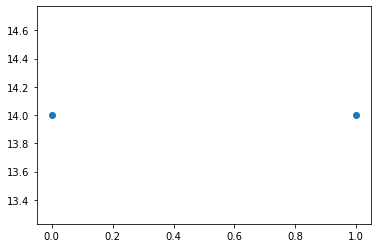

Episode =  1
Episode =  2
Episode =  3
Episode =  4
Episode =  5
Episode =  6
Episode =  7
Episode =  8
Episode =  9
Episode =  10
Episode =  11
Episode =  12
Episode =  13
Episode =  14
Episode =  15
Episode =  16
Episode =  17
Episode =  18
Episode =  19
Episode =  20
Episode =  21
Episode =  22
Episode =  23
Episode =  24
Episode =  25
Episode =  26
Episode =  27
Episode =  28
Episode =  29
Episode =  30
Episode =  31
Episode =  32
Episode =  33
Episode =  34
Episode =  35
Episode =  36
Episode =  37
Episode =  38
Episode =  39
Episode =  40
Episode =  41
Episode =  42
Episode =  43
Episode =  44
Episode =  45
Episode =  46
Episode =  47
Episode =  48
Episode =  49
Episode =  50
Episode =  51
Episode =  52
Episode =  53
Episode =  54
Episode =  55
Episode =  56
Episode =  57
Episode =  58
Episode =  59
Episode =  60
Episode =  61
Episode =  62
Episode =  63
Episode =  64
Episode =  65
Episode =  66
Episode =  67
Episode =  68
Episode =  69
Episode =  70
Episode =  71
Episode =  72
E

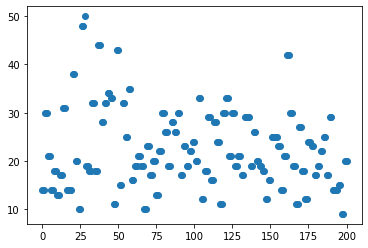

Episode =  101
Episode =  102
Episode =  103
Episode =  104
Episode =  105
Episode =  106
Episode =  107
Episode =  108
Episode =  109
Episode =  110
Episode =  111
Episode =  112
Episode =  113
Episode =  114
Episode =  115
Episode =  116
Episode =  117
Episode =  118
Episode =  119
Episode =  120
Episode =  121
Episode =  122
Episode =  123
Episode =  124
Episode =  125
Episode =  126
Episode =  127
Episode =  128
Episode =  129
Episode =  130
Episode =  131
Episode =  132
Episode =  133
Episode =  134
Episode =  135
Episode =  136
Episode =  137
Episode =  138
Episode =  139
Episode =  140
Episode =  141
Episode =  142
Episode =  143
Episode =  144
Episode =  145
Episode =  146
Episode =  147
Episode =  148
Episode =  149
Episode =  150
Episode =  151
Episode =  152
Episode =  153
Episode =  154
Episode =  155
Episode =  156
Episode =  157
Episode =  158
Episode =  159
Episode =  160
Episode =  161
Episode =  162
Episode =  163
Episode =  164
Episode =  165
Episode =  166
Episode = 

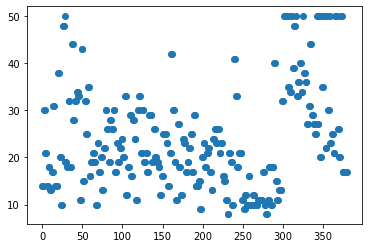

Episode =  201
Episode =  202
Episode =  203
Episode =  204
Episode =  205
Episode =  206
Episode =  207
Episode =  208
Episode =  209
Episode =  210
Episode =  211
Episode =  212
Episode =  213
Episode =  214
Episode =  215
Episode =  216
Episode =  217
Episode =  218
Episode =  219
Episode =  220
Episode =  221
Episode =  222
Episode =  223
Episode =  224
Episode =  225
Episode =  226
Episode =  227
Episode =  228
Episode =  229
Episode =  230
Episode =  231
Episode =  232
Episode =  233
Episode =  234
Episode =  235
Episode =  236
Episode =  237
Episode =  238
Episode =  239
Episode =  240
Episode =  241
Episode =  242
Episode =  243
Episode =  244
Episode =  245
Episode =  246
Episode =  247
Episode =  248
Episode =  249
Episode =  250
Episode =  251
Episode =  252
Episode =  253
Episode =  254
Episode =  255
Episode =  256
Episode =  257
Episode =  258
Episode =  259
Episode =  260
Episode =  261
Episode =  262
Episode =  263
Episode =  264
Episode =  265
Episode =  266
Episode = 

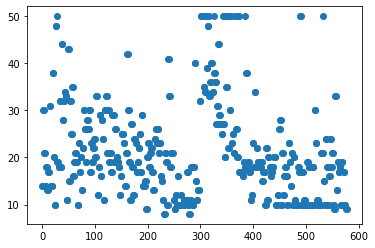

Episode =  301
Episode =  302
Episode =  303
Episode =  304
Episode =  305
Episode =  306
Episode =  307
Episode =  308
Episode =  309
Episode =  310
Episode =  311
Episode =  312
Episode =  313
Episode =  314
Episode =  315
Episode =  316
Episode =  317
Episode =  318
Episode =  319
Episode =  320
Episode =  321
Episode =  322
Episode =  323
Episode =  324
Episode =  325
Episode =  326
Episode =  327
Episode =  328
Episode =  329
Episode =  330
Episode =  331
Episode =  332
Episode =  333
Episode =  334
Episode =  335
Episode =  336
Episode =  337
Episode =  338
Episode =  339
Episode =  340
Episode =  341
Episode =  342
Episode =  343
Episode =  344
Episode =  345
Episode =  346
Episode =  347
Episode =  348
Episode =  349
Episode =  350
Episode =  351
Episode =  352
Episode =  353
Episode =  354
Episode =  355
Episode =  356
Episode =  357
Episode =  358
Episode =  359
Episode =  360
Episode =  361
Episode =  362
Episode =  363
Episode =  364
Episode =  365
Episode =  366
Episode = 

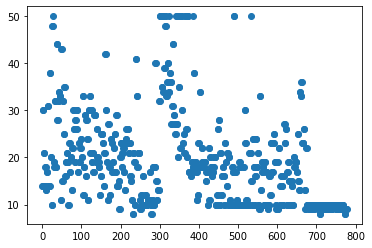

Episode =  401
Episode =  402
Episode =  403
Episode =  404
Episode =  405
Episode =  406
Episode =  407
Episode =  408
Episode =  409
Episode =  410
Episode =  411
Episode =  412
Episode =  413
Episode =  414
Episode =  415
Episode =  416
Episode =  417
Episode =  418
Episode =  419
Episode =  420
Episode =  421
Episode =  422
Episode =  423
Episode =  424
Episode =  425
Episode =  426
Episode =  427
Episode =  428
Episode =  429
Episode =  430
Episode =  431
Episode =  432
Episode =  433
Episode =  434
Episode =  435
Episode =  436
Episode =  437
Episode =  438
Episode =  439
Episode =  440
Episode =  441
Episode =  442
Episode =  443
Episode =  444
Episode =  445
Episode =  446
Episode =  447
Episode =  448
Episode =  449
Episode =  450
Episode =  451
Episode =  452
Episode =  453
Episode =  454
Episode =  455
Episode =  456
Episode =  457
Episode =  458
Episode =  459
Episode =  460
Episode =  461
Episode =  462
Episode =  463
Episode =  464
Episode =  465
Episode =  466
Episode = 

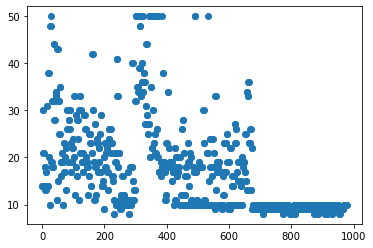

Episode =  501
Episode =  502
Episode =  503
Episode =  504
Episode =  505
Episode =  506
Episode =  507
Episode =  508
Episode =  509
Episode =  510
Episode =  511
Episode =  512
Episode =  513
Episode =  514
Episode =  515
Episode =  516
Episode =  517
Episode =  518
Episode =  519
Episode =  520
Episode =  521
Episode =  522
Episode =  523
Episode =  524
Episode =  525
Episode =  526
Episode =  527
Episode =  528
Episode =  529
Episode =  530
Episode =  531
Episode =  532
Episode =  533
Episode =  534
Episode =  535
Episode =  536
Episode =  537
Episode =  538
Episode =  539
Episode =  540
Episode =  541
Episode =  542
Episode =  543
Episode =  544
Episode =  545
Episode =  546
Episode =  547
Episode =  548
Episode =  549
Episode =  550
Episode =  551
Episode =  552
Episode =  553
Episode =  554
Episode =  555
Episode =  556
Episode =  557
Episode =  558
Episode =  559
Episode =  560
Episode =  561
Episode =  562
Episode =  563
Episode =  564
Episode =  565
Episode =  566
Episode = 

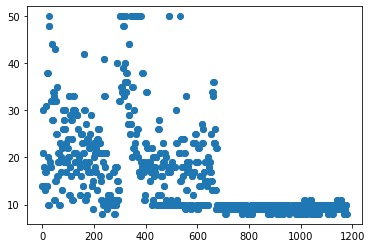

Episode =  601
Episode =  602
Episode =  603
Episode =  604
Episode =  605
Episode =  606
Episode =  607
Episode =  608
Episode =  609
Episode =  610
Episode =  611
Episode =  612
Episode =  613
Episode =  614
Episode =  615
Episode =  616
Episode =  617
Episode =  618
Episode =  619
Episode =  620
Episode =  621
Episode =  622
Episode =  623
Episode =  624
Episode =  625
Episode =  626
Episode =  627
Episode =  628
Episode =  629
Episode =  630
Episode =  631
Episode =  632
Episode =  633
Episode =  634
Episode =  635
Episode =  636
Episode =  637
Episode =  638
Episode =  639
Episode =  640
Episode =  641
Episode =  642
Episode =  643
Episode =  644
Episode =  645
Episode =  646
Episode =  647
Episode =  648
Episode =  649
Episode =  650
Episode =  651
Episode =  652
Episode =  653
Episode =  654
Episode =  655
Episode =  656
Episode =  657
Episode =  658
Episode =  659
Episode =  660
Episode =  661
Episode =  662
Episode =  663
Episode =  664
Episode =  665
Episode =  666
Episode = 

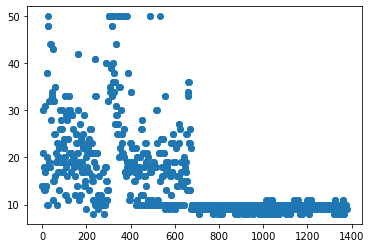

Episode =  701
Episode =  702
Episode =  703
Episode =  704
Episode =  705
Episode =  706
Episode =  707
Episode =  708
Episode =  709
Episode =  710
Episode =  711
Episode =  712
Episode =  713
Episode =  714
Episode =  715
Episode =  716
Episode =  717
Episode =  718
Episode =  719
Episode =  720
Episode =  721
Episode =  722
Episode =  723
Episode =  724
Episode =  725
Episode =  726
Episode =  727
Episode =  728
Episode =  729
Episode =  730
Episode =  731
Episode =  732
Episode =  733
Episode =  734
Episode =  735
Episode =  736
Episode =  737
Episode =  738
Episode =  739
Episode =  740
Episode =  741
Episode =  742
Episode =  743
Episode =  744
Episode =  745
Episode =  746
Episode =  747
Episode =  748
Episode =  749
Episode =  750
Episode =  751
Episode =  752
Episode =  753
Episode =  754
Episode =  755
Episode =  756
Episode =  757
Episode =  758
Episode =  759
Episode =  760
Episode =  761
Episode =  762
Episode =  763
Episode =  764
Episode =  765
Episode =  766
Episode = 

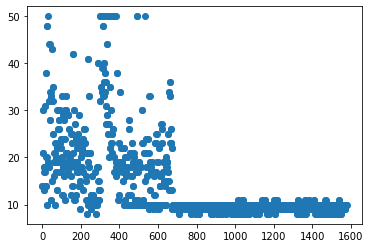

Episode =  801
Episode =  802
Episode =  803
Episode =  804
Episode =  805
Episode =  806
Episode =  807
Episode =  808
Episode =  809
Episode =  810
Episode =  811
Episode =  812
Episode =  813
Episode =  814
Episode =  815
Episode =  816
Episode =  817
Episode =  818
Episode =  819
Episode =  820
Episode =  821
Episode =  822
Episode =  823
Episode =  824
Episode =  825
Episode =  826
Episode =  827
Episode =  828
Episode =  829
Episode =  830
Episode =  831
Episode =  832
Episode =  833
Episode =  834
Episode =  835
Episode =  836
Episode =  837
Episode =  838
Episode =  839
Episode =  840
Episode =  841
Episode =  842
Episode =  843
Episode =  844
Episode =  845
Episode =  846
Episode =  847
Episode =  848
Episode =  849
Episode =  850
Episode =  851
Episode =  852
Episode =  853
Episode =  854
Episode =  855
Episode =  856
Episode =  857
Episode =  858
Episode =  859
Episode =  860
Episode =  861
Episode =  862
Episode =  863
Episode =  864
Episode =  865
Episode =  866
Episode = 

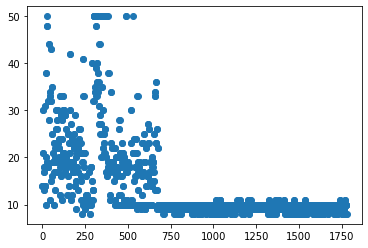

Episode =  901
Episode =  902
Episode =  903
Episode =  904
Episode =  905
Episode =  906
Episode =  907
Episode =  908
Episode =  909
Episode =  910
Episode =  911
Episode =  912
Episode =  913
Episode =  914
Episode =  915
Episode =  916
Episode =  917
Episode =  918
Episode =  919
Episode =  920
Episode =  921
Episode =  922
Episode =  923
Episode =  924
Episode =  925
Episode =  926
Episode =  927
Episode =  928
Episode =  929
Episode =  930
Episode =  931
Episode =  932
Episode =  933
Episode =  934
Episode =  935
Episode =  936
Episode =  937
Episode =  938
Episode =  939
Episode =  940
Episode =  941
Episode =  942
Episode =  943
Episode =  944
Episode =  945
Episode =  946
Episode =  947
Episode =  948
Episode =  949
Episode =  950
Episode =  951
Episode =  952
Episode =  953
Episode =  954
Episode =  955
Episode =  956
Episode =  957
Episode =  958
Episode =  959
Episode =  960
Episode =  961
Episode =  962
Episode =  963
Episode =  964
Episode =  965
Episode =  966
Episode = 

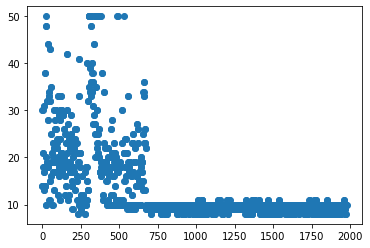

Episode =  1001
Episode =  1002
Episode =  1003
Episode =  1004
Episode =  1005
Episode =  1006
Episode =  1007
Episode =  1008
Episode =  1009
Episode =  1010
Episode =  1011
Episode =  1012
Episode =  1013
Episode =  1014
Episode =  1015
Episode =  1016
Episode =  1017
Episode =  1018
Episode =  1019
Episode =  1020
Episode =  1021
Episode =  1022
Episode =  1023
Episode =  1024
Episode =  1025
Episode =  1026
Episode =  1027
Episode =  1028
Episode =  1029
Episode =  1030
Episode =  1031
Episode =  1032
Episode =  1033
Episode =  1034
Episode =  1035
Episode =  1036
Episode =  1037
Episode =  1038
Episode =  1039
Episode =  1040
Episode =  1041
Episode =  1042
Episode =  1043
Episode =  1044
Episode =  1045
Episode =  1046
Episode =  1047
Episode =  1048
Episode =  1049
Episode =  1050
Episode =  1051
Episode =  1052
Episode =  1053
Episode =  1054
Episode =  1055
Episode =  1056
Episode =  1057
Episode =  1058
Episode =  1059
Episode =  1060
Episode =  1061
Episode =  1062
Episode 

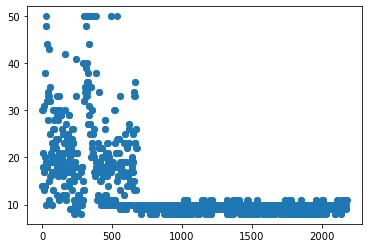

Episode =  1101
Episode =  1102
Episode =  1103
Episode =  1104
Episode =  1105
Episode =  1106
Episode =  1107
Episode =  1108
Episode =  1109
Episode =  1110
Episode =  1111
Episode =  1112
Episode =  1113
Episode =  1114
Episode =  1115
Episode =  1116
Episode =  1117
Episode =  1118
Episode =  1119
Episode =  1120
Episode =  1121
Episode =  1122
Episode =  1123
Episode =  1124
Episode =  1125
Episode =  1126
Episode =  1127
Episode =  1128
Episode =  1129
Episode =  1130
Episode =  1131
Episode =  1132
Episode =  1133
Episode =  1134
Episode =  1135
Episode =  1136
Episode =  1137
Episode =  1138
Episode =  1139
Episode =  1140
Episode =  1141
Episode =  1142
Episode =  1143
Episode =  1144
Episode =  1145
Episode =  1146
Episode =  1147
Episode =  1148
Episode =  1149
Episode =  1150
Episode =  1151
Episode =  1152
Episode =  1153
Episode =  1154
Episode =  1155
Episode =  1156
Episode =  1157
Episode =  1158
Episode =  1159
Episode =  1160
Episode =  1161
Episode =  1162
Episode 

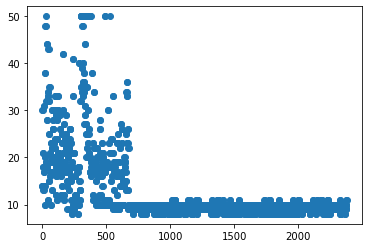

Episode =  1201
Episode =  1202
Episode =  1203
Episode =  1204
Episode =  1205
Episode =  1206
Episode =  1207
Episode =  1208
Episode =  1209
Episode =  1210
Episode =  1211
Episode =  1212
Episode =  1213
Episode =  1214
Episode =  1215
Episode =  1216
Episode =  1217
Episode =  1218
Episode =  1219
Episode =  1220
Episode =  1221
Episode =  1222
Episode =  1223
Episode =  1224
Episode =  1225
Episode =  1226
Episode =  1227
Episode =  1228
Episode =  1229
Episode =  1230
Episode =  1231
Episode =  1232
Episode =  1233
Episode =  1234
Episode =  1235
Episode =  1236
Episode =  1237
Episode =  1238
Episode =  1239
Episode =  1240
Episode =  1241
Episode =  1242
Episode =  1243
Episode =  1244
Episode =  1245
Episode =  1246
Episode =  1247
Episode =  1248
Episode =  1249
Episode =  1250
Episode =  1251
Episode =  1252
Episode =  1253
Episode =  1254
Episode =  1255
Episode =  1256
Episode =  1257
Episode =  1258
Episode =  1259
Episode =  1260
Episode =  1261
Episode =  1262
Episode 

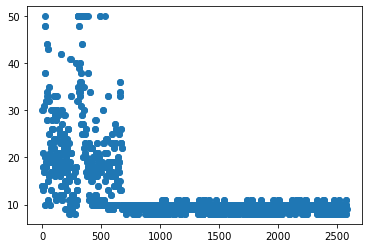

Episode =  1301
Episode =  1302
Episode =  1303
Episode =  1304
Episode =  1305
Episode =  1306
Episode =  1307
Episode =  1308
Episode =  1309
Episode =  1310
Episode =  1311
Episode =  1312
Episode =  1313
Episode =  1314
Episode =  1315
Episode =  1316
Episode =  1317
Episode =  1318
Episode =  1319
Episode =  1320
Episode =  1321
Episode =  1322
Episode =  1323
Episode =  1324
Episode =  1325
Episode =  1326
Episode =  1327
Episode =  1328
Episode =  1329
Episode =  1330
Episode =  1331
Episode =  1332
Episode =  1333
Episode =  1334
Episode =  1335
Episode =  1336
Episode =  1337
Episode =  1338
Episode =  1339
Episode =  1340
Episode =  1341
Episode =  1342
Episode =  1343
Episode =  1344
Episode =  1345
Episode =  1346
Episode =  1347
Episode =  1348
Episode =  1349
Episode =  1350
Episode =  1351
Episode =  1352
Episode =  1353
Episode =  1354
Episode =  1355
Episode =  1356
Episode =  1357
Episode =  1358
Episode =  1359
Episode =  1360
Episode =  1361
Episode =  1362
Episode 

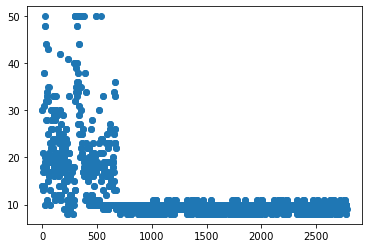

Episode =  1401
Episode =  1402
Episode =  1403
Episode =  1404
Episode =  1405
Episode =  1406
Episode =  1407
Episode =  1408
Episode =  1409
Episode =  1410
Episode =  1411
Episode =  1412
Episode =  1413
Episode =  1414
Episode =  1415
Episode =  1416
Episode =  1417
Episode =  1418
Episode =  1419
Episode =  1420
Episode =  1421
Episode =  1422
Episode =  1423
Episode =  1424
Episode =  1425
Episode =  1426
Episode =  1427
Episode =  1428
Episode =  1429
Episode =  1430
Episode =  1431
Episode =  1432
Episode =  1433
Episode =  1434
Episode =  1435
Episode =  1436
Episode =  1437
Episode =  1438
Episode =  1439
Episode =  1440
Episode =  1441
Episode =  1442
Episode =  1443
Episode =  1444
Episode =  1445
Episode =  1446
Episode =  1447
Episode =  1448
Episode =  1449
Episode =  1450
Episode =  1451
Episode =  1452
Episode =  1453
Episode =  1454
Episode =  1455
Episode =  1456
Episode =  1457
Episode =  1458
Episode =  1459
Episode =  1460


KeyboardInterrupt: 

In [186]:
for i in range(episodes):
    print("Episode = ", i)
    state = torch.tensor(env.reset(), dtype=torch.float32)

    done = False
    steps = 0
    eps_rew = 0 
    while not done and steps<50:
        if np.random.uniform(0,1)<eps:
            action = env.action_space.sample()
        else:
            action = np.argmax(model(state).detach().numpy())
        next_state, reward, done, info = env.step(action)
        replay_buffer.append((state, next_state, reward, done, action))
        if len(replay_buffer)>batch_size:
            loss = compute_td_loss(batch_size)
        eps = eps/(1 + 0.001)
        eps_rew += reward 
        if done:
            tot_rewards.append(eps_rew)
            break
        
        state = next_state
        state = torch.tensor(state, dtype=torch.float32)
        steps += 1
    tot_rewards.append(eps_rew)
    
    if(i%100)==0:
        plt.scatter(np.arange(len(tot_rewards)), tot_rewards)
        plt.show()

In [ ]:
#Plot
plt.plot(tot_rewards)

In [25]:
#Render the final environment
state, info = env.reset(seed=42, return_info=True)
import time
for i in range(100):
    
    print("i = ", i)
    env.render()
    
    state = torch.tensor(state, dtype=torch.float32)
    action = np.argmax(model(state).detach().numpy())
    print("action = ", action)
    state, reward, done, info = env.step(action)

    if done:
        state, info = env.reset(return_info=True)
env.close()

i =  0


c:\users\thoma\anaconda3\envs\custom_atari_env\lib\site-packages\gym\core.py:58: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  "You are calling render method, "


action =  3
i =  1


c:\users\thoma\anaconda3\envs\custom_atari_env\lib\site-packages\gym\core.py:58: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  "You are calling render method, "


action =  3
i =  2
action =  3
i =  3
action =  3
i =  4
action =  3
i =  5
action =  3
i =  6
action =  3
i =  7
action =  3
i =  8
action =  3
i =  9
action =  3
i =  10
action =  3
i =  11
action =  3
i =  12
action =  3
i =  13
action =  3
i =  14
action =  3
i =  15
action =  3
i =  16
action =  3
i =  17
action =  3
i =  18
action =  3
i =  19
action =  3
i =  20
action =  3
i =  21
action =  3
i =  22
action =  3
i =  23
action =  3
i =  24
action =  3
i =  25
action =  3
i =  26
action =  3
i =  27
action =  3
i =  28
action =  3
i =  29
action =  3
i =  30
action =  3
i =  31
action =  3
i =  32
action =  3
i =  33
action =  3
i =  34
action =  3
i =  35
action =  3
i =  36
action =  3
i =  37
action =  3
i =  38
action =  3
i =  39
action =  3
i =  40
action =  3
i =  41
action =  3
i =  42
action =  3
i =  43
action =  3
i =  44
action =  3
i =  45
action =  3
i =  46
action =  3
i =  47
action =  3
i =  48
action =  3
i =  49
action =  3
i =  50
action =  3
i =  51
action =

KeyboardInterrupt: 